### Modelling and Forecasting Brent Crude Oil with Auto Regressive Integrated Moving Average (ARIMA)


1. **Importing Libraries**: The first section of the code imports necessary libraries for data manipulation, visualization, and time series analysis.


In [1]:
#%%
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


2. **Loading Data**: The data is loaded from a pre processed CSV file into a pandas DataFrame. The index of the DataFrame is set to be the date.


In [2]:
#%%

# Load data from csv file
data = pd.read_csv('Modified Data.csv', index_col=[0], parse_dates=True)
data.head()

,Returns
2006-01-01,25.30
2006-02-01,21.79
2006-03-01,24.15
2006-04-01,26.33
2006-05-01,27.64


The shape of the data shows the number of months and columns as (x,y)


In [3]:
data.shape

(208, 1)

3. **Plotting Data**: The data is plotted using `Plotly`, a Python graphing library. This provides a visual representation of the time series data.


In [4]:
#%%
# Plot data
fig = px.line(data, x=data.index, y='Returns', title='Brent Crude Oil Prices')
fig.show()

**Checking Stationarity with Augmented Dickey-Fuller Test**: The Augmented Dickey-Fuller test is used to check if the time series is stationary. A stationary time series’ properties do not depend on the time at which the series is observed.


In [5]:
#%%

def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %f' % result[2])
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print(f"Data may be non-stationary, consider differencing")

print("""Testing stationarity of data:""")
adf_test(data)

Testing stationarity of data:
ADF Statistic: -2.649951
p-value: 0.083106
Number of lags used: 2.000000
Data may be non-stationary, consider differencing


7. **Decomposing Time Series**: The time series is decomposed into trend, seasonal, and residual components.


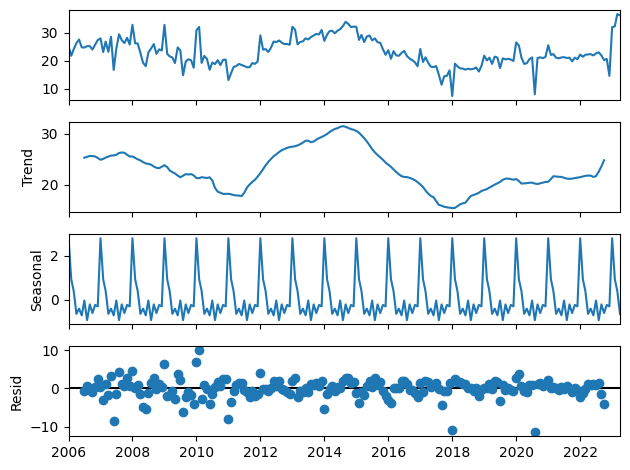

In [6]:
#%%

# Decompose time series into trend, seasonal, and residual components
result = seasonal_decompose(data, model='additive')
result.plot()
plt.show()

8. **Differencing to Make the Series Stationary**: If the series is not stationary, it is differenced. Differencing is the transformation of the series to make it stationary.


<Axes: title={'center': '2nd Differencing'}>

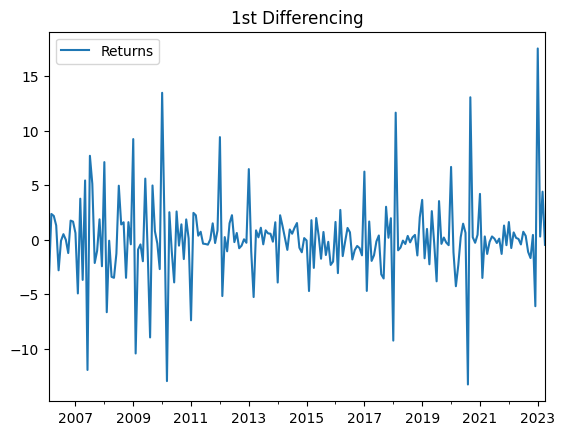

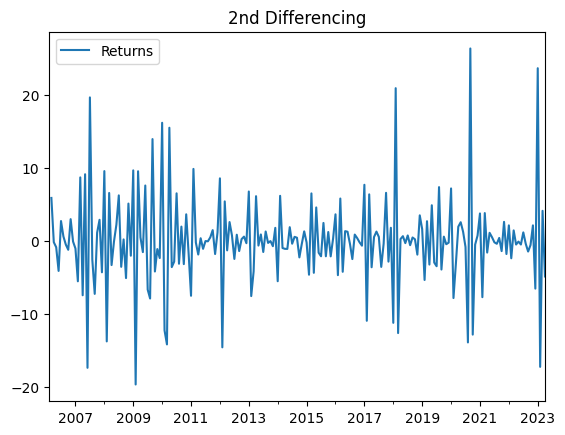

In [7]:
#%%

# Differencing to make the series stationary and plot the differenced series
diff = data.diff()[1:] # [1:] to remove NaN value
diff_2 = diff.diff()

# plot and add legend in top right corner with plotly subplots
diff.plot(title="1st Differencing")
diff_2.plot(title="2nd Differencing")


**Determining the Order of Differencing**: The ndiffs function is used to determine the minimum number of differencing needed to make the series stationary.


In [8]:
#%%

# number of  differencing for stationary series with ndiffs

# Adf Test
print('ADF:', ndiffs(data, test='adf'))
# KPSS test
print('KPSS:', ndiffs(data, test='kpss'))
# PP test:
print('PP:', ndiffs(data, test='pp'))

ADF: 1
KPSS: 1
PP: 0


**Determining the Order of the AR and MA terms**: The Partial Autocorrelation Function `PACF` and the Autocorrelation Function `ACF` are plotted to determine the order of the `AR` and `MA` terms.


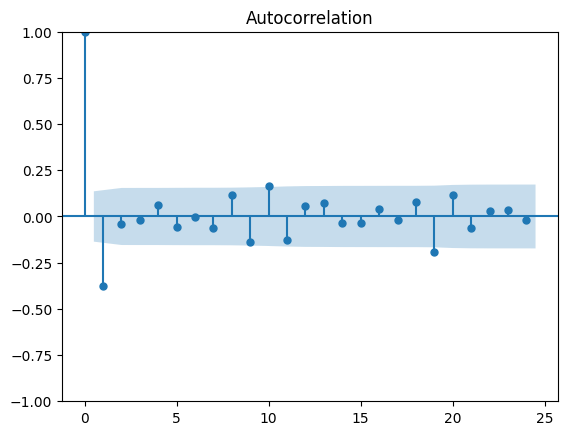

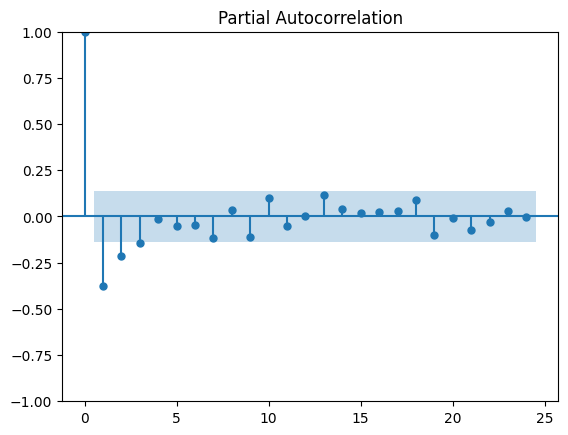

In [9]:
#%%
# Find order of MA term Q
plot_acf(diff).show()
# Order of auto regressive term P
plot_pacf(diff).show()

In [13]:
adf_test(diff)

ADF Statistic: -11.694615
p-value: 0.000000
Number of lags used: 2.000000
Data is likely stationary.


4. **Splitting Data into Train and Test Sets**:

- The data is split into training and testing sets based on a specified date.
- The training set is used to train the model, and
- The testing set is used to evaluate the model’s performance


In [10]:
#%%
# set the train and test data with start dates
train_start_date = '2006-01-01'
test_start_date = '2019-01-01'

# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Returns']]
test = data.copy()[data.index >= test_start_date][['Returns']]

# train = data.iloc[:len(data)-24] 
# test = data.iloc[len(data)-24:] 

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (156, 1)
Test data shape:  (52, 1)


5. **Plotting Train and Test Splits**: The training and testing data are plotted to visualize the split.


In [11]:
#%%

# Plot train and test splits
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Returns'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Returns'], mode='lines', name='Test'))
fig.update_layout(title='Train and Test Split', xaxis_title='Date', yaxis_title='Returns')
fig.show()

**Model Selection with Auto ARIMA**: The auto_arima function is used to automatically select the best `ARIMA` model based on the **Akaike Information Criterion** `AIC`.


In [15]:
#%%

# use auto_arima to find best parameters
model = pm.auto_arima(diff, seasonal=True, stepwise=True, information_criterion='bic', suppress_warnings=True, trace=True, error_action="ignore")
print(f"ARIMA Order: {model.order}")
print(f"Seasonal Order: {model.seasonal_order}")
print(f"AIC: {model.aic()}")
print(f"BIC: {model.bic()}")
print(f"HQIC: {model.hqic()}")


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=1111.245, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=1141.664, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=1115.214, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=1100.924, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=1136.374, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=1104.766, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=1104.963, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=1109.899, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=1095.786, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=1099.603, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=1099.809, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=1109.995, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=1104.726, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.700 seconds
ARIMA Order: (0, 0, 1)

**Model Diagnostics**: The residuals of the model are checked to ensure that the assumptions of the model are met.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -542.560
Date:                Wed, 22 May 2024   AIC                           1089.120
Time:                        16:16:37   BIC                           1095.786
Sample:                    01-01-2006   HQIC                          1091.816
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5414      0.040    -13.520      0.000      -0.620      -0.463
sigma2        11.0516      0.664     16.643      0.000       9.750      12.353
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               112.97
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.34
Prob(H) (two-sided):                  0.80   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

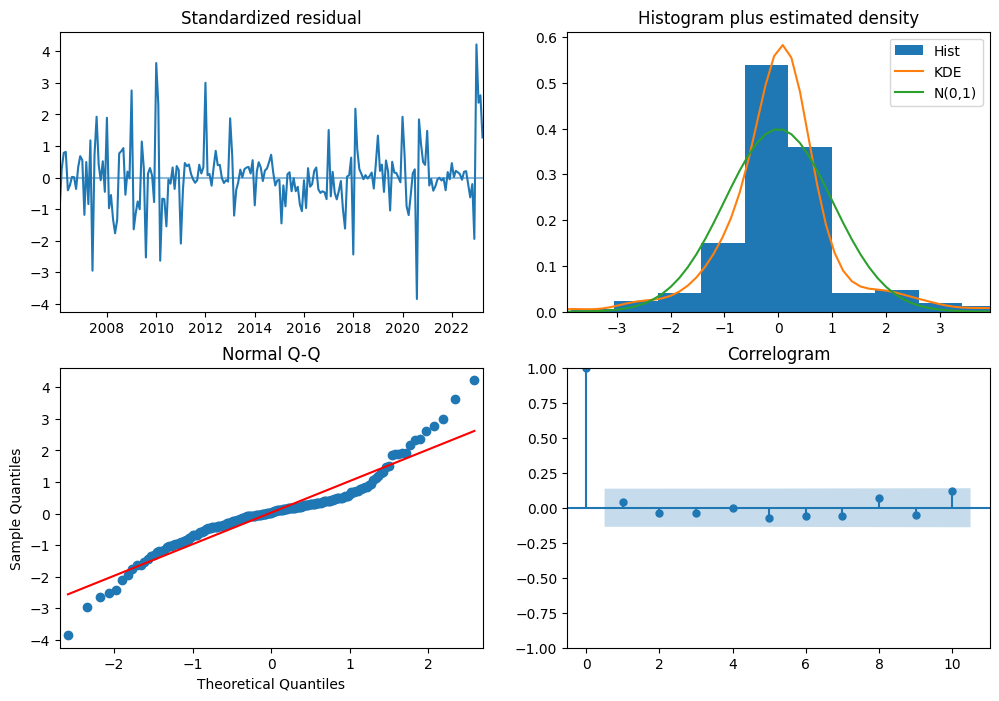

In [ ]:
#%%
model.plot_diagnostics(figsize=(12, 8)).show()
model.summary()

**Model Fitting**: The model is fitted to the training data.


In [ ]:
#%%
# Fit the model with the rraining set and best parameters found by auto_arima 
model = SARIMAX(train, order= model.order)
model_fit = model.fit()
# residuals = model_fit.resid

# Print the summary of the model
model_fit.summary(alpha=0.05)
model_fit.summary(alpha=0.10)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                  156
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -396.558
Date:                Wed, 22 May 2024   AIC                            797.116
Time:                        16:16:43   BIC                            803.203
Sample:                    01-01-2006   HQIC                           799.589
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
ma.L1         -0.6043      0.051    -11.955      0.000      -0.687      -0.521
sigma2         9.7383      0.739     13.180      0.000       8.523      10.954
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                48.40
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Prediction**: The model is used to make predictions on the test data.


In [ ]:
test.head()

,Returns
2019-01-01,21.83
2019-02-01,20.13
2019-03-01,21.12
2019-04-01,18.87
2019-05-01,21.49


In [ ]:
# dynamic=False means that forecasts at each point are generated using the full history up to that point
predictions = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
residuals = test['Returns'] - predictions

In [ ]:
predictions.tail()

2022-08-01    51.783188
2022-09-01    51.783188
2022-10-01    51.783188
2022-11-01    51.783188
2022-12-01    51.783188
Freq: MS, Name: predicted_mean, dtype: float64

Plots of the residuals of after fitting the model


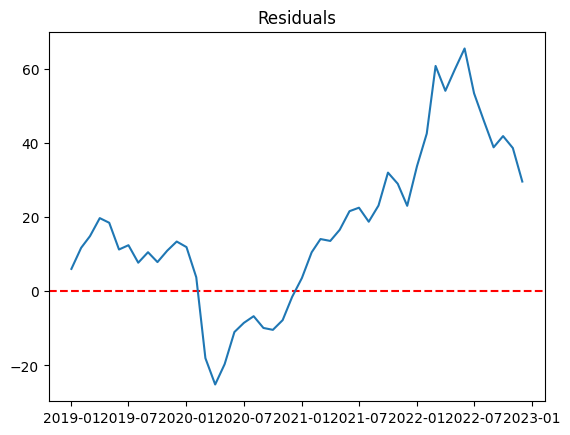

In [ ]:
# Plot residuals
plt.axhline(y=0, color='red', linestyle='--')
plt.plot(residuals)
plt.title('Residuals')
plt.show()


15. **Model Evaluation**: The model’s performance is evaluated using the **Root Mean Squared Error** `RMSE`, **Mean Absolute Error** `MAE`, and **Mean Absolute Percentage Error** `MAPE`.


In [ ]:
#%%

# Calculate evaluation metrics
print(""" Error Metrics """)

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)


print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'Mean Absolute Percentage Error: {mape*100:.3f}%')




 Error Metrics 
Mean Squared Error: 40.912
Mean Absolute Error: 5.072
Root Mean Squared Error: 6.396
Mean Absolute Percentage Error: 22.579%


16. **Plotting Actual vs Predicted Prices**: The actual and predicted prices are plotted.


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['Returns'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index, y=predictions, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted Returns', xaxis_title='Date', yaxis_title='Price')
fig.show()


17. **Forecasting Future Prices**: The model is used to forecast future prices.


In [ ]:
# Forecasting with confidence intervals for the next 24 months

future_dates = pd.date_range(start='2023-01-01', periods=24, freq='M') 

# Forecast with 95% confidence interval
forecast_obj_95 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_95 = forecast_obj_95.predicted_mean
conf_int_95 = forecast_obj_95.conf_int(alpha=0.05)

# Forecast with 90% confidence interval
forecast_obj_90 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
conf_int_90 = forecast_obj_90.conf_int(alpha=0.10)

# Plot the forecast with confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Returns'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_95, mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 0], mode='lines', name='Lower 95% CI', line=dict(color='rgba(255,0,0,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 1], mode='lines', name='Upper 95% CI', line=dict(color='rgba(255,0,0,0.5)'), fill='tonexty'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 0], mode='lines', name='Lower 90% CI', line=dict(color='rgba(0,0,255,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 1], mode='lines', name='Upper 90% CI', line=dict(color='rgba(0,0,255,0.5)'), fill='tonexty'))
fig.update_layout(title='Brent Crude Oil Returns Forecast (with Confidence Intervals)', xaxis_title='Date', yaxis_title='Returns')
fig.show()


Applying a rolling window forecast


In [ ]:
# use rolling window to forecast the next 24 months
window_size = 24 # 24 months
forecast = [] # to store the forecasted values
for i in range(len(test)):
    train_window = train.append(test.iloc[:i]) # add the test data to the training data
    model = SARIMAX(train_window, order=model.order) # create the model
    model_fit = model.fit() # fit the model
    forecast.append(model_fit.forecast(steps=1)[0]) # forecast the next month

# Calculate evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)



In [ ]:
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Absolute Percentage Error: {mape*100:.3f}%')

Mean Squared Error: 15.300
Root Mean Squared Error: 3.912
Mean Absolute Error: 2.388
Mean Absolute Percentage Error: 12.126%


In [ ]:
# plot the actual and forecasted values
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['Returns'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index, y=forecast, mode='lines', name='Forecast'))
fig.update_layout(title='Actual vs Forecasted Returns', xaxis_title='Date', yaxis_title='Returns')
fig.show()

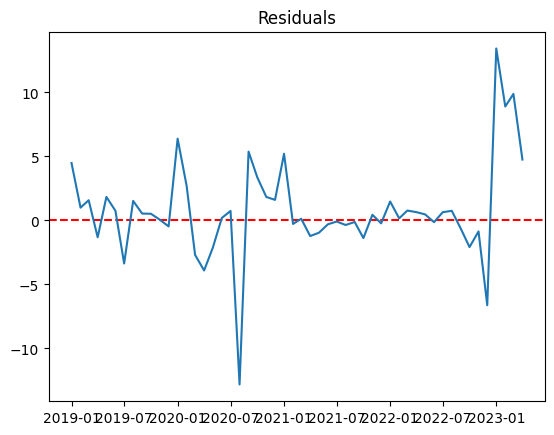

In [ ]:
# plot the residuals
residuals = test['Returns'] - forecast
plt.axhline(y=0, color='red', linestyle='--')
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [ ]:
# Forecast with confidence intervals for the next 24 months
future_dates = pd.date_range(start='2023-05-01', periods=20, freq='M')

# Forecast with 95% confidence interval
forecast_obj_95 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_95 = forecast_obj_95.predicted_mean
conf_int_95 = forecast_obj_95.conf_int(alpha=0.05)

# Forecast with 90% confidence interval
forecast_obj_90 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_90 = forecast_obj_90.predicted_mean
conf_int_90 = forecast_obj_90.conf_int(alpha=0.10)

# Plot the forecast with confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Returns'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_95, mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 0], mode='lines', name='Lower 95% CI', line=dict(color='rgba(255,0,0,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 1], mode='lines', name='Upper 95% CI', line=dict(color='rgba(255,0,0,0.5)'), fill='tonexty'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 0], mode='lines', name='Lower 90% CI', line=dict(color='rgba(0,0,255,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 1], mode='lines', name='Upper 90% CI', line=dict(color='rgba(0,0,255,0.5)'), fill='tonexty'))
fig.update_layout(title='Brent Crude Oil Returns Forecast (with Confidence Intervals)', xaxis_title='Date', yaxis_title='Returns')
fig.show()
